# Evaluación y selección de modelos

### Boletin de Abraham Trashorras Rivas


## Importamos las librerías a utilizar

In [1]:
import numpy as np
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import pickle
import matplotlib.pyplot as plt
import matplotlib

In [2]:
%matplotlib inline
matplotlib.style.use('ggplot')
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)  # Para evitar warnings en la generación de algunas gráficas

## Definimos variables globales

In [3]:
SEED_VALUE = 1  # Valor que se indica en el boletín
DATASET_DELIMITER = ',' # Ambos bloodTransfusion.data y EnergyEfficiency.data lo usan

## Ejercicio 1: Construye el árbol de clasificación (sin podar) mediante CART

Creamos el dataset a partir de los datos mostrados en el boletín

In [4]:
df_1 = [[4, 3, -1, 1],
         [-3, -1, -1, 0],
         [3, -2, 0, 0],
         [1, 4, 0, 1],
         [-2, 3, 1, 0],
         [-3, 5, 5, 0]]
df_1

[[4, 3, -1, 1],
 [-3, -1, -1, 0],
 [3, -2, 0, 0],
 [1, 4, 0, 1],
 [-2, 3, 1, 0],
 [-3, 5, 5, 0]]

#### Vamos a asumir que Y solo contiene dos clases, 0 y 1. Primero creamos la funcion para calcular la entropia

In [5]:
def calcular_entropia(grupos, clases):
    total_muestras = float(sum([len(grupo) for grupo in grupos]))
    entropia_total = 0.0

    for grupo in grupos:
        tamano_grupo = float(len(grupo))
        if tamano_grupo == 0:
            continue
        entropia_grupo = 0.0

        for clase in clases:
            prop_clase = [fila[-1] for fila in grupo].count(clase) / tamano_grupo
            if prop_clase > 0:
                entropia_grupo -= prop_clase * np.log(prop_clase)

        entropia_total += entropia_grupo * (tamano_grupo / total_muestras)

    return entropia_total


In [6]:
def dividir_conjunto(indice, valor, datos):
    conjunto_izq, conjunto_der = list(), list()
    for fila in datos:
        if fila[indice] < valor:
            conjunto_izq.append(fila)
        else:
            conjunto_der.append(fila)
    return conjunto_izq, conjunto_der

#### Ahora creamos la funcion para encontrar la mejor division

In [7]:
def elegir_division(datos):
    clases = list(set(fila[-1] for fila in datos))
    mejor_indice, mejor_valor, mejor_entropia, mejores_grupos = np.Inf, np.Inf, np.Inf, None

    for indice in range(len(datos[0]) - 1):
        sorted_data = sorted(datos, key=lambda fila: fila[indice])
        for i in range(1, len(sorted_data)):
            valor = (sorted_data[i][indice] + sorted_data[i - 1][indice]) / 2.0
            grupos = dividir_conjunto(indice, valor, datos)
            entropia = calcular_entropia(grupos, clases)
            if entropia < mejor_entropia:
                mejor_indice, mejor_valor, mejor_entropia, mejores_grupos = indice, valor, entropia, grupos

    return {'indice': mejor_indice, 'valor': mejor_valor, 'entropia': mejor_entropia, 'grupos': mejores_grupos, 'terminal': False}

#### Ya tenemos lo necesario para crear la función que cree el arbol de decision

In [8]:
# Creamos el nodo terminal
def crear_nodo_terminal(grupo):
    resultados = [fila[-1] for fila in grupo]
    return {'clase': max(set(resultados), key=resultados.count), 'miembros': grupo, 'terminal': True}

# Creamos las divisiones de los hijos para un nodo o lo hacemos terminal
def crear_divisiones(nodo, tamano_min, profundidad):
    izq, der = nodo['grupos']
    del(nodo['grupos'])

    # Primero exploramos hijo izquierdo
    if len(izq) <= tamano_min:
        nodo['izquierdo'] = crear_nodo_terminal(izq)
    elif calcular_entropia([izq], list(set(fila[-1] for fila in izq))) == 0.0:
        nodo['izquierdo'] = crear_nodo_terminal(izq)
    else:
        nodo['izquierdo'] = elegir_division(izq)
        crear_divisiones(nodo['izquierdo'], tamano_min, profundidad+1)

    # Despues exploramos hijo derecho
    if len(der) <= tamano_min:
        nodo['derecho'] = crear_nodo_terminal(der)
    elif calcular_entropia([der], list(set(fila[-1] for fila in der))) == 0.0:
        nodo['derecho'] = crear_nodo_terminal(der)
    else:
        nodo['derecho'] = elegir_division(der)
        crear_divisiones(nodo['derecho'], tamano_min, profundidad+1)

# Construimos el árbol de decisión
def construir_arbol(datos, tamano_min=1):
    raiz = elegir_division(datos)
    crear_divisiones(raiz, tamano_min, 1)
    return raiz

#### Vamos a crear una funcion auxiliar para visualizar el arbol

In [9]:
def imprimir_arbol(nodo, profundidad=0):
    if not nodo['terminal']:
        print '{}[X{} < {}] -> Entropía {}'.format(' ' * profundidad, nodo['indice'] + 1, nodo['valor'], nodo['entropia'])
        imprimir_arbol(nodo['izquierdo'], profundidad + 1)
        imprimir_arbol(nodo['derecho'], profundidad + 1)
    else:
        print '{}[Clase {}] -> Miembros: {}'.format(' ' * profundidad, nodo['clase'], nodo['miembros'])

In [10]:
arbol = construir_arbol(df_1)
imprimir_arbol(arbol)

[X1 < -0.5] -> Entropía 0.318257084147
 [Clase 0] -> Miembros: [[-3, -1, -1, 0], [-2, 3, 1, 0], [-3, 5, 5, 0]]
 [X2 < 0.5] -> Entropía 0.0
  [Clase 0] -> Miembros: [[3, -2, 0, 0]]
  [Clase 1] -> Miembros: [[4, 3, -1, 1], [1, 4, 0, 1]]


## Ejercicio 2: Problema de clasificación Blood Transfusion Service Center

In [11]:
df_2 = pd.read_csv("bloodTransfusion.data", 
                      delimiter=DATASET_DELIMITER,
                      skiprows=1,
                      header=None,
                      names = ["Recency", "Frequency", "Monetary", "Time", "DonatedInMarch"])
df_2

Recency  Frequency  Monetary  Time  DonatedInMarch
0          2         50     12500    98               1
1          0         13      3250    28               1
2          1         16      4000    35               1
3          2         20      5000    45               1
4          1         24      6000    77               0
5          4          4      1000     4               0
6          2          7      1750    14               1
7          1         12      3000    35               0
8          2          9      2250    22               1
9          5         46     11500    98               1
10         4         23      5750    58               0
11         0          3       750     4               0
12         2         10      2500    28               1
13         1         13      3250    47               0
14         2          6      1500    15               1
15         2          5      1250    11               1
16         2         14      3500    48               1
17         2         15      3750    49               1
18         2          6      1500    15               1
19         2          3       750     4               1
20         2          3       750     4               1
21         4         11      2750    28               0
22         2          6      1500    16               1
23         2          6      1500    16               1
24         9          9      2250    16               0
25         4         14      3500    40               0
26         4          6      1500    14               0
27         4         12      3000    34               1
28         4          5      1250    11               1
29         4          8      2000    21               0
..       ...        ...       ...   ...             ...
718       21          3       750    35               0
719       23          8      2000    69               0
720       21          3       750    38               0
721       23          3       750    35               0
722       21          3       750    40               0
723       23          2       500    28               0
724       21          1       250    21               0
725       21          1       250    21               0
726       25          6      1500    50               0
727       21          1       250    21               0
728       21          1       250    21               0
729       23          3       750    39               0
730       21          2       500    33               0
731       14          3       750    79               0
732       23          1       250    23               1
733       23          1       250    23               0
734       23          1       250    23               0
735       23          1       250    23               0
736       23          1       250    23               0
737       23          1       250    23               0
738       23          1       250    23               0
739       23          4      1000    52               0
740       23          1       250    23               0
741       23          7      1750    88               0
742       16          3       750    86               0
743       23          2       500    38               0
744       21          2       500    52               0
745       23          3       750    62               0
746       39          1       250    39               0
747       72          1       250    72               0

[748 rows x 5 columns]

Los datos en este dataframe incluyen:
- Recency: meses desde la última donación.
- Frequency: número total de donaciones.
- Monetary: cantidad total de sangre donada en centímetros cúbicos (c.c.).
- Time: meses desde la primera donación.
- DonatedInMarch: variable a predecir, mide si se ha donado en Marzo de 2007.

### Apartado a: La clase que implementa el algoritmo CART en problemas de clasificación en scikit-learn es sklearn.tree.DecisionTreeClassifier. Revisa los parámetros y métodos que tiene

In [12]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree.tree:

class DecisionTreeClassifier(BaseDecisionTree, sklearn.base.ClassifierMixin)
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : string, optional (default="best")
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best random split.
 |  
 |  max_depth : int or None, optional (default=None)
 |      The maximum depth of the tree. If None, then nodes are expanded until
 |      all leaves are pure or until all leaves contain less than
 |      min_samples_split samples.
 |  
 |  min_samples_split : int, float, optional (default=2)

### Apartado b: Divide los datos en entrenamiento (80%) y test (20%)

Dividimos los datos en variables predictoras X y la variable dependiente Y. Tenemos que usar stratify para asegurarnos que ambas clases son correctamente representadas entre el train y el test.

In [16]:
X = df_2.drop('DonatedInMarch', axis=1)
Y = df_2['DonatedInMarch']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=SEED_VALUE, stratify=Y)

Vamos también a estandarizar los datos, en este caso solo las varaibles predictoras ya que se trata de un problema de clasificación.

In [17]:
scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """
/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [18]:
print("mean [Recency, Frequency, Monetary, Time]: {}".format(scaler.mean_))
print("std [Recency, Frequency, Monetary, Time]: {}".format(scaler.scale_))

mean [Recency, Frequency, Monetary, Time]: [   9.5083612     5.63712375 1409.28093645   34.87959866]
std [Recency, Frequency, Monetary, Time]: [   7.89304107    5.89317612 1473.29403119   24.72995729]


### Apartado c: Realiza la experimentación con DecisionTreeClassifier

In [19]:
hyperparameters = {'min_samples_split': range(2, 220, 1)}
decision_tree = DecisionTreeClassifier(criterion='entropy', random_state=SEED_VALUE)
modelCV = GridSearchCV(decision_tree,
                       hyperparameters,
                       cv=5,
                       scoring='accuracy',
                       return_train_score=True)

np.random.seed(SEED_VALUE)
modelCV.fit(X_train_scaled, Y_train)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70...200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [20]:
cv_results = pd.DataFrame(modelCV.cv_results_)
# Si hacemos aqui la transformacion del error es mucho mas comódo
cv_results['mean_test_score'] = 1 - cv_results['mean_test_score']
cv_results.loc[:,
               ['param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']
              ].sort_values(by='rank_test_score')

param_min_samples_split  mean_test_score  std_test_score  rank_test_score
77                       79         0.225753        0.014680                1
76                       78         0.225753        0.014680                1
74                       76         0.225753        0.014680                1
73                       75         0.225753        0.014680                1
36                       38         0.225753        0.031895                1
75                       77         0.225753        0.014680                1
38                       40         0.225753        0.031895                1
72                       74         0.225753        0.014680                1
71                       73         0.225753        0.014680                1
37                       39         0.225753        0.031895                1
87                       89         0.227425        0.032036               11
69                       71         0.227425        0.034030               11
81                       83         0.227425        0.032036               11
82                       84         0.227425        0.032036               11
83                       85         0.227425        0.032036               11
84                       86         0.227425        0.032036               11
85                       87         0.227425        0.032036               11
86                       88         0.227425        0.032036               11
88                       90         0.227425        0.032036               11
108                     110         0.227425        0.032036               11
90                       92         0.227425        0.032036               11
107                     109         0.227425        0.032036               11
106                     108         0.227425        0.032036               11
105                     107         0.227425        0.032036               11
89                       91         0.227425        0.032036               11
103                     105         0.227425        0.032036               11
102                     104         0.227425        0.032036               11
101                     103         0.227425        0.032036               11
100                     102         0.227425        0.032036               11
99                      101         0.227425        0.032036               11
..                      ...              ...             ...              ...
132                     134         0.255853        0.029708              173
133                     135         0.255853        0.029708              173
163                     165         0.255853        0.018414              173
162                     164         0.255853        0.018414              173
161                     163         0.255853        0.018414              173
160                     162         0.255853        0.018414              173
159                     161         0.255853        0.018414              173
158                     160         0.255853        0.018414              173
131                     133         0.255853        0.029708              173
157                     159         0.255853        0.018414              173
155                     157         0.255853        0.018414              173
154                     156         0.255853        0.018414              173
153                     155         0.255853        0.018414              173
152                     154         0.255853        0.018414              173
135                     137         0.255853        0.029708              173
134                     136         0.255853        0.029708              173
156                     158         0.255853        0.018414              173
8                        10         0.259197        0.040558              206
9                        11         0.260870        0.047333              207
137                     13

#### Muestra la gráfica del error de entrenamiento con validación cruzada (5-CV) frente al valor del hiper-parámetro. ¿Cuál es el menor error de validación cruzada, su desviación estándar y el valor del hiper-parámetro para el que se consigue? ¿Cuál es el valor del hiperparámetro si se aplicase la regla de una desviación estándar? En caso de que haya varios modelos con error mínimo, debe seleccionarse siempre el más simple

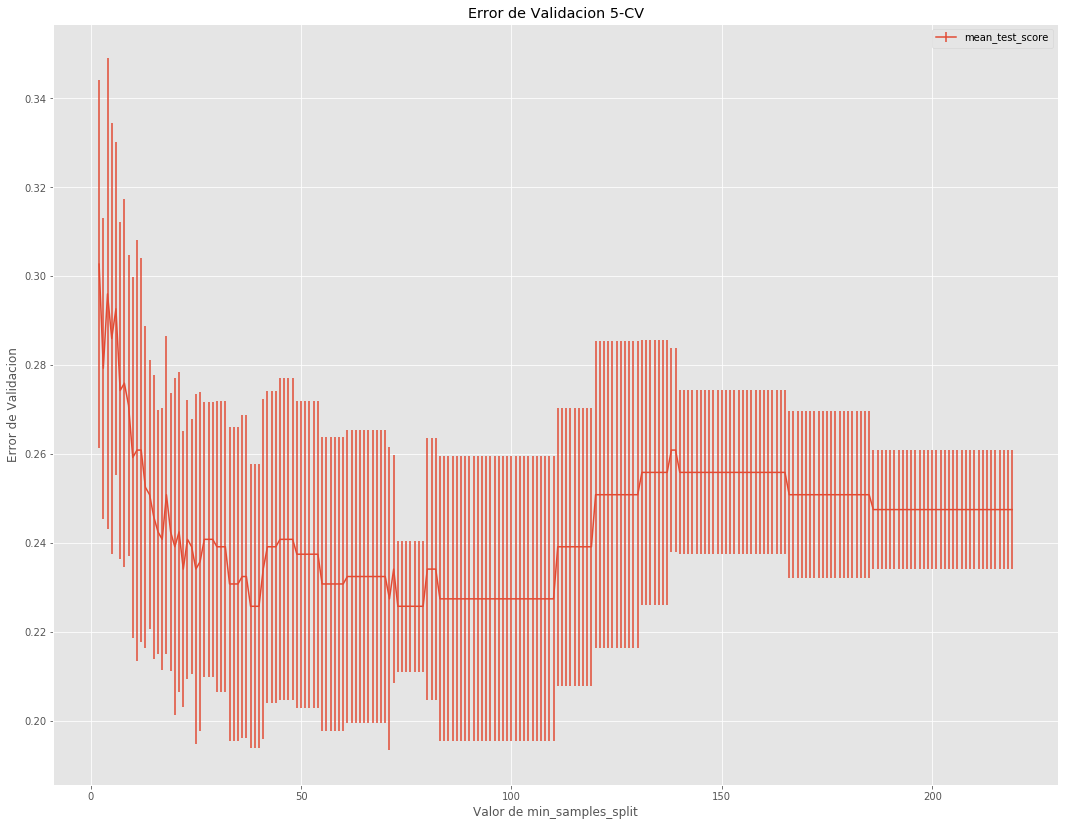

In [21]:
plt.figure(figsize=(18, 14))

plt.title("Error de Validacion 5-CV")
plt.errorbar(cv_results['param_min_samples_split'], cv_results['mean_test_score'], cv_results['std_test_score'])
plt.xlabel("Valor de min_samples_split")
plt.ylabel("Error de Validacion")
plt.legend(loc='upper right')
plt.show()

Datos del Hiperparámetro con menor error de validación cruzada y mas simple

In [22]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
best = cv_results_best.loc[:,
                    ['param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']
                   ].sort_values(by='param_min_samples_split', ascending=False
                    ).head(1)
best

param_min_samples_split  mean_test_score  std_test_score  rank_test_score
77                      79         0.225753         0.01468                1

Si aplicamos la regla de una desviación típica, calculamos otra vez el mejor valor:

In [23]:
mean_best = best['mean_test_score'].iloc[0]
std_best = best['std_test_score'].iloc[0]

threshold = mean_best + std_best

print("Limite: {}".format(threshold))

Limite: 0.240432191666


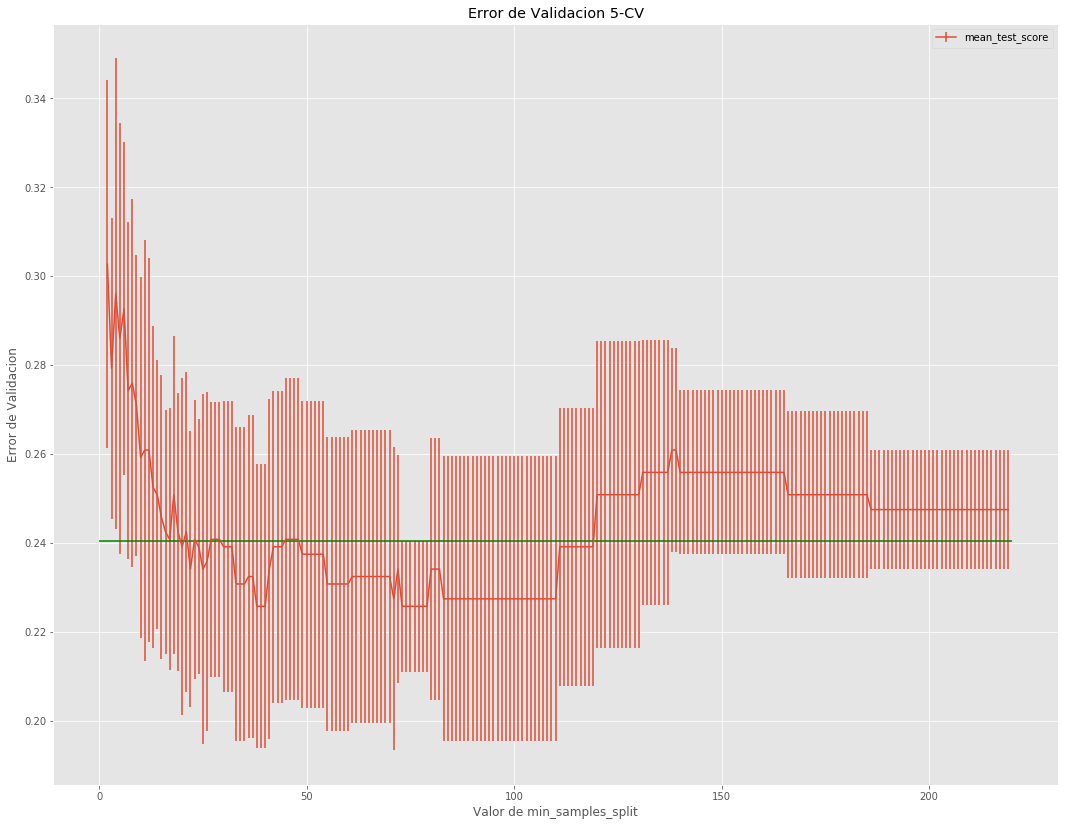

In [26]:
plt.figure(figsize=(18, 14))

plt.title("Error de Validacion 5-CV")
plt.errorbar(cv_results['param_min_samples_split'], cv_results['mean_test_score'], cv_results['std_test_score'])
plt.hlines(y=threshold, xmin=0, xmax=220, colors='green')
plt.xlabel("Valor de min_samples_split")
plt.ylabel("Error de Validacion")
plt.legend(loc='upper right')
plt.show()

In [27]:
cv_results_best = cv_results[
                cv_results['mean_test_score'] <= threshold
            ].sort_values(by='param_min_samples_split', ascending=False)

best_std = cv_results_best.loc[:, ['param_min_samples_split','mean_test_score','std_test_score','rank_test_score']
            ].sort_values(
                by='param_min_samples_split', 
                ascending=False
            ).head(1)
best_std

param_min_samples_split  mean_test_score  std_test_score  rank_test_score
117                     119          0.23913        0.031228               75

#### Muestra la gráfica del error de test frente al valor del hiper-parámetro, y valora si la gráfica del error de entrenamiento con validación cruzada ha hecho una buena estimación del error de test. ¿Cuál es el error de test para el valor del hiper-parámetro seleccionado por la validación cruzada? 

In [28]:
test_errors = []
for params in modelCV.cv_results_['params']:
    model = DecisionTreeClassifier(criterion='entropy', random_state=SEED_VALUE, **params)
    model.fit(X_train_scaled, Y_train)
    Y_pred_test = model.predict(X_test_scaled)
    test_error = 1 - accuracy_score(Y_test, Y_pred_test)
    test_errors.append(test_error)

Ahora podemos dibujar la gráfica

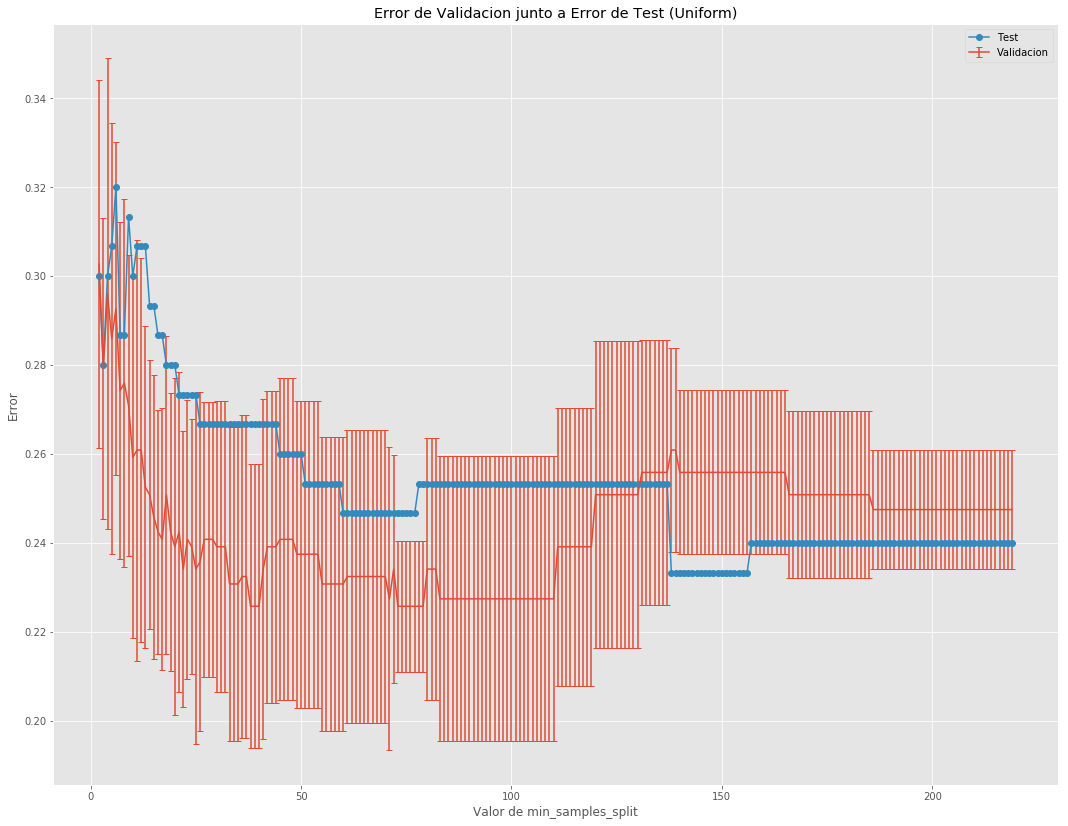

In [29]:
fig, ax = plt.subplots(figsize=(18, 14))
ax.set_title("Error de Validacion junto a Error de Test (Uniform)")
ax.errorbar(cv_results['param_min_samples_split'], cv_results['mean_test_score'], yerr=cv_results['std_test_score'], label='Validacion', capsize=3)
ax.plot(cv_results['param_min_samples_split'], test_errors, label='Test', marker='o')
ax.set_xlabel("Valor de min_samples_split")
ax.set_ylabel("Error")
ax.legend(loc='upper right')
plt.show()

¿Cuál es el menor error de test y el valor del hiper‐parámetro para el que se consigue? 

In [34]:
min_error_index = test_errors.index(min(test_errors))
min_test_error = float('inf')
min_samples_split_value = -1

# Iteramos sobre los errores de test y los valores de min_samples_split
for error, params in zip(test_errors, modelCV.cv_results_['params']):
    min_samples_split = params['min_samples_split']
    # Verificar si este error es igual al mínimo actual y si min_samples_split es mayor
    if error <= min_test_error and min_samples_split > min_samples_split_value:
        min_test_error = error
        min_samples_split_value = min_samples_split

print("Minimo error de test: {}, con hiperparámetro {}".format(min_test_error, min_samples_split_value))

Minimo error de test: 0.233333333333, con hiperparámetro 156


Ahora podemos extraer el valor del error de test para 79, el que obtuvo el mejor error de validación

In [35]:
print("Error de test para el mejor modelo seleccionado por validación cruzada: {}".format(test_errors[77]))

Error de test para el mejor modelo seleccionado por validación cruzada: 0.253333333333


Ahora podemos extraer el valor del error de test para 119, el que obtuvo el mejor error con la regla de desviacion tipica

In [37]:
print("Error de test para el mejor modelo seleccionado por validación cruzada")
print("Con la regla de desviacion tipica: {}".format(test_errors[117]))

Error de test para el mejor modelo seleccionado por validación cruzada
Con la regla de desviacion tipica: 0.253333333333


## Ejercicio 3: Repite el ejercicio 2 pero para el problema de regresión Energy Efficiency con la variable de salida (Y2)

Primero vamos a importar, mostrar y estudiar los datos. Especificamos el nombre de las columnas para evitar errores con espacion inesperados.

In [31]:
df_3 = pd.read_csv("EnergyEfficiency.data", 
                      delimiter=DATASET_DELIMITER,
                       skiprows=1,
                       header=None,
                       names=["X1", "X2", "X3", "X4", "X5", "X6", "X7", "X8", "Y2"])
df_3

X1     X2     X3      X4   X5  X6   X7  X8     Y2
0    0.98  514.5  294.0  110.25  7.0   2  0.0   0  21.33
1    0.98  514.5  294.0  110.25  7.0   3  0.0   0  21.33
2    0.98  514.5  294.0  110.25  7.0   4  0.0   0  21.33
3    0.98  514.5  294.0  110.25  7.0   5  0.0   0  21.33
4    0.90  563.5  318.5  122.50  7.0   2  0.0   0  28.28
5    0.90  563.5  318.5  122.50  7.0   3  0.0   0  25.38
6    0.90  563.5  318.5  122.50  7.0   4  0.0   0  25.16
7    0.90  563.5  318.5  122.50  7.0   5  0.0   0  29.60
8    0.86  588.0  294.0  147.00  7.0   2  0.0   0  27.30
9    0.86  588.0  294.0  147.00  7.0   3  0.0   0  21.97
10   0.86  588.0  294.0  147.00  7.0   4  0.0   0  23.49
11   0.86  588.0  294.0  147.00  7.0   5  0.0   0  27.87
12   0.82  612.5  318.5  147.00  7.0   2  0.0   0  23.77
13   0.82  612.5  318.5  147.00  7.0   3  0.0   0  21.46
14   0.82  612.5  318.5  147.00  7.0   4  0.0   0  21.16
15   0.82  612.5  318.5  147.00  7.0   5  0.0   0  24.93
16   0.79  637.0  343.0  147.00  7.0   2  0.0   0  37.73
17   0.79  637.0  343.0  147.00  7.0   3  0.0   0  31.27
18   0.79  637.0  343.0  147.00  7.0   4  0.0   0  30.93
19   0.79  637.0  343.0  147.00  7.0   5  0.0   0  39.44
20   0.76  661.5  416.5  122.50  7.0   2  0.0   0  29.79
21   0.76  661.5  416.5  122.50  7.0   3  0.0   0  29.68
22   0.76  661.5  416.5  122.50  7.0   4  0.0   0  29.79
23   0.76  661.5  416.5  122.50  7.0   5  0.0   0  29.40
24   0.74  686.0  245.0  220.50  3.5   2  0.0   0  10.90
25   0.74  686.0  245.0  220.50  3.5   3  0.0   0  11.19
26   0.74  686.0  245.0  220.50  3.5   4  0.0   0  10.94
27   0.74  686.0  245.0  220.50  3.5   5  0.0   0  11.17
28   0.71  710.5  269.5  220.50  3.5   2  0.0   0  11.27
29   0.71  710.5  269.5  220.50  3.5   3  0.0   0  11.72
..    ...    ...    ...     ...  ...  ..  ...  ..    ...
738  0.79  637.0  343.0  147.00  7.0   4  0.4   5  47.01
739  0.79  637.0  343.0  147.00  7.0   5  0.4   5  44.87
740  0.76  661.5  416.5  122.50  7.0   2  0.4   5  39.37
741  0.76  661.5  416.5  122.50  7.0   3  0.4   5  39.80
742  0.76  661.5  416.5  122.50  7.0   4  0.4   5  37.79
743  0.76  661.5  416.5  122.50  7.0   5  0.4   5  38.18
744  0.74  686.0  245.0  220.50  3.5   2  0.4   5  16.69
745  0.74  686.0  245.0  220.50  3.5   3  0.4   5  16.62
746  0.74  686.0  245.0  220.50  3.5   4  0.4   5  16.94
747  0.74  686.0  245.0  220.50  3.5   5  0.4   5  16.70
748  0.71  710.5  269.5  220.50  3.5   2  0.4   5  15.59
749  0.71  710.5  269.5  220.50  3.5   3  0.4   5  14.58
750  0.71  710.5  269.5  220.50  3.5   4  0.4   5  15.33
751  0.71  710.5  269.5  220.50  3.5   5  0.4   5  15.31
752  0.69  735.0  294.0  220.50  3.5   2  0.4   5  16.63
753  0.69  735.0  294.0  220.50  3.5   3  0.4   5  15.87
754  0.69  735.0  294.0  220.50  3.5   4  0.4   5  16.54
755  0.69  735.0  294.0  220.50  3.5   5  0.4   5  16.74
756  0.66  759.5  318.5  220.50  3.5   2  0.4   5  17.64
757  0.66  759.5  318.5  220.50  3.5   3  0.4   5  17.79
758  0.66  759.5  318.5  220.50  3.5   4  0.4   5  17.55
759  0.66  759.5  318.5  220.50  3.5   5  0.4   5  18.06
760  0.64  784.0  343.0  220.50  3.5   2  0.4   5  20.82
761  0.64  784.0  343.0  220.50  3.5   3  0.4   5  20.21
762  0.64  784.0  343.0  220.50  3.5   4  0.4   5  20.71
763  0.64  784.0  343.0  220.50  3.5   5  0.4   5  21.40
764  0.62  808.5  367.5  220.50  3.5   2  0.4   5  16.88
765  0.62  808.5  367.5  220.50  3.5   3  0.4   5  17.11
766  0.62  808.5  367.5  220.50  3.5   4  0.4   5  16.61
767  0.62  808.5  367.5  220.50  3.5   5  0.4   5  16.03

[768 rows x 9 columns]

Vamos a dividir los datos en entrada X y salida Y ademas de crear la division de entrenamiento y prueba

In [32]:
X = df_3.drop('Y2', axis=1)
Y = df_3['Y2']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED_VALUE)

Vamos a estandarizar tanto X como Y ya que estamos ante un problema de regresión, aunque Y no haria falta

In [33]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_Y = StandardScaler()
Y_train_scaled = scaler_Y.fit_transform(Y_train.values.reshape(-1, 1)).flatten()

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [50]:
hyperparameters = {'min_samples_split': range(2, 150, 1)}
decision_tree = DecisionTreeRegressor(random_state=SEED_VALUE)
modelCV = GridSearchCV(decision_tree,
                       hyperparameters,
                       cv=5,
                       scoring='neg_mean_squared_error',
                       return_train_score=True)

np.random.seed(SEED_VALUE)
modelCV.fit(X_train_scaled, Y_train)

/opt/cesga/anaconda/Anaconda2-2018.12/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1, splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70...130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

Ahora tenemos que desestandarizar los datos, multiplicandolos por la varianza de las observaciones de Y del conjunto de entrenamiento

In [51]:
Desestandarizado = False

In [52]:
y_train_var = np.var(Y_train)
cv_results = pd.DataFrame(modelCV.cv_results_)
if(Desestandarizado):
    cv_results['mean_test_score'] = cv_results['mean_test_score'].abs() * y_train_var
    cv_results['std_test_score'] = cv_results['std_test_score'] * y_train_var
else:
    cv_results['mean_test_score'] = -1 * cv_results['mean_test_score']

Vamos a dibujar la grafica de entrenamiento

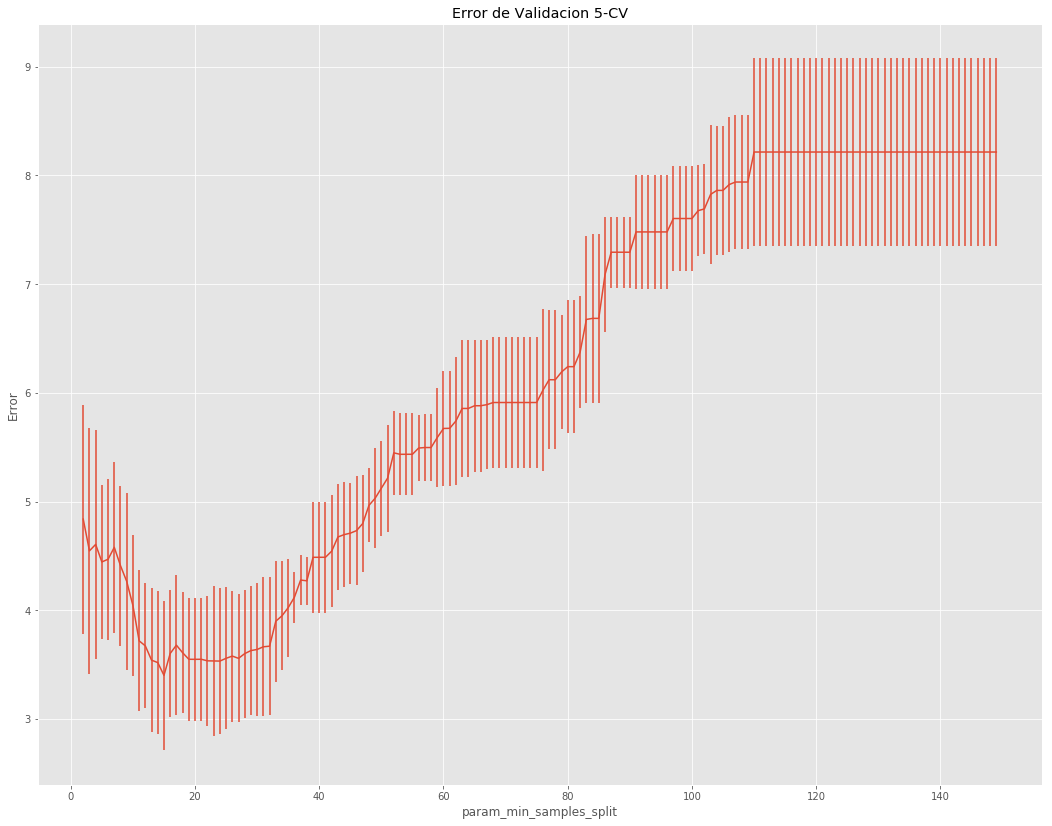

In [53]:
plt.figure(figsize=(18, 14))
plt.errorbar(cv_results['param_min_samples_split'], cv_results['mean_test_score'], yerr=cv_results['std_test_score'])
plt.xlabel('param_min_samples_split')
plt.ylabel('Error')
plt.title('Error de Validacion 5-CV')
plt.show()

In [54]:
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]
best = cv_results_best.loc[:,
                    ['param_min_samples_split', 'mean_test_score', 'std_test_score', 'rank_test_score']
                   ].sort_values(by='param_min_samples_split', ascending=False
                    ).head(1)
best

param_min_samples_split  mean_test_score  std_test_score  rank_test_score
13                      15         3.400928        0.688564                1

Ahora vamos a calcular cuál es el valor del hiperparámetro si se aplicase la regla de una desviación estándar

In [55]:
mean_best = best['mean_test_score'].iloc[0]
std_best = best['std_test_score'].iloc[0]

threshold = mean_best + std_best

print("Limite: {}".format(threshold))

Limite: 4.08949175134


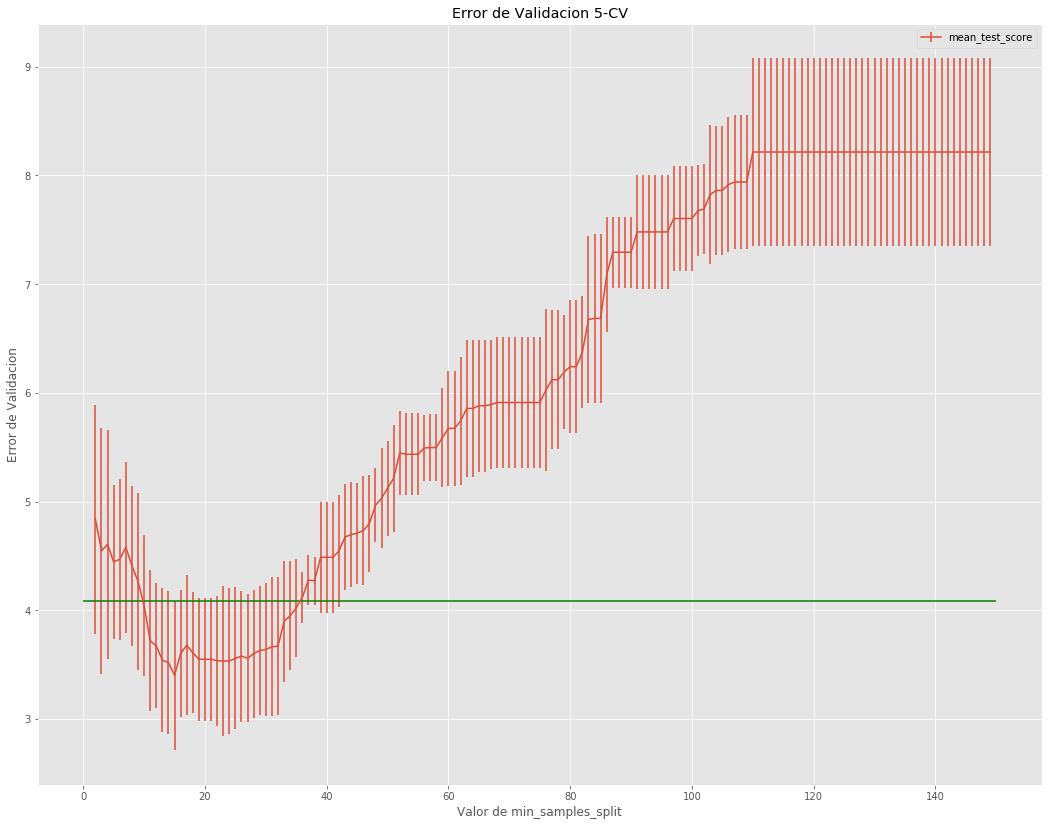

In [56]:
plt.figure(figsize=(18, 14))

plt.title("Error de Validacion 5-CV")
plt.errorbar(cv_results['param_min_samples_split'], cv_results['mean_test_score'], cv_results['std_test_score'])
plt.hlines(y=threshold, xmin=0, xmax=150, colors='green')
plt.xlabel("Valor de min_samples_split")
plt.ylabel("Error de Validacion")
plt.legend(loc='upper right')
plt.show()

In [57]:
cv_results_best = cv_results[
                cv_results['mean_test_score'] <= threshold
            ].sort_values(by='param_min_samples_split', ascending=False)

best_std = cv_results_best.loc[:, ['param_min_samples_split','mean_test_score','std_test_score','rank_test_score']
            ].sort_values(
                by='param_min_samples_split', 
                ascending=False
            ).head(1)
best_std

param_min_samples_split  mean_test_score  std_test_score  rank_test_score
33                      35         4.024066        0.450152               25

Con todo esto estudiado, ahora podemos dibujar la grafica del error de test frente al valor del hiper‐parámetro

In [62]:
test_errors = []
for params in modelCV.cv_results_['params']:
    model = DecisionTreeRegressor(criterion='mse', random_state=SEED_VALUE, **params)
    model.fit(X_train_scaled, Y_train)
    Y_pred_test = model.predict(X_test_scaled)
    test_error = mean_squared_error(Y_test, Y_pred_test)
    test_errors.append(test_error)

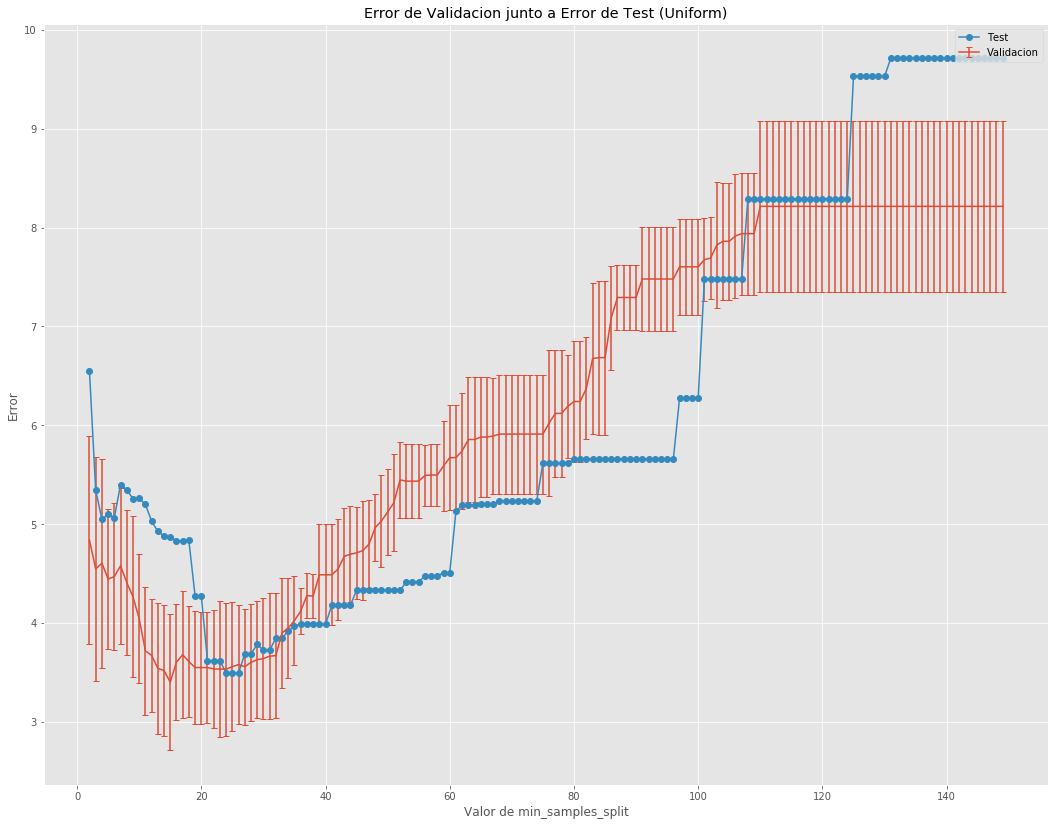

In [63]:
fig, ax = plt.subplots(figsize=(18, 14))
ax.set_title("Error de Validacion junto a Error de Test (Uniform)")
ax.errorbar(cv_results['param_min_samples_split'], cv_results['mean_test_score'], yerr=cv_results['std_test_score'], label='Validacion', capsize=3)
ax.plot(cv_results['param_min_samples_split'], test_errors, label='Test', marker='o')
ax.set_xlabel("Valor de min_samples_split")
ax.set_ylabel("Error")
ax.legend(loc='upper right')
plt.show()

Vamos a consultar el mejor valor de test y su hiperparametro

In [64]:
min_error_index = test_errors.index(min(test_errors))
min_test_error = float('inf')
min_samples_split_value = -1

# Iteramos sobre los errores de test y los valores de min_samples_split
for error, params in zip(test_errors, modelCV.cv_results_['params']):
    min_samples_split = params['min_samples_split']
    # Verificar si este error es igual al mínimo actual y si min_samples_split es mayor
    if error <= min_test_error and min_samples_split > min_samples_split_value:
        min_test_error = error
        min_samples_split_value = min_samples_split

print("Minimo error de test: {}, con hiperparámetro {}".format(min_test_error, min_samples_split_value))

Minimo error de test: 3.49205180827, con hiperparámetro 26


Para el mejor valor del error de validacion:

In [73]:
print("Error de test para el mejor valor de validacion cruzada: {}".format(test_errors[13])

Error de test para el mejor valor de validacion cruzada: 4.87006996158


Para el mejor valor del error de validacion con la regla de una desviacion estandar:

In [74]:
print("Error de test para el mejor valor de validacion cruzada con la regla de desviacion estandar: {}".format(test_errors[33])

Error de test para el mejor valor de validacion cruzada con la regla de desviacion estandar: 3.9709026559
